In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde


In [ ]:
try:
    df = pd.read_csv("/content/data.csv", encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv("/content/data.csv", encoding='latin1')
df = df[["no2"]].dropna()

x = df["no2"].values


/tmp/ipython-input-4182958650.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/data.csv", encoding='latin1')


In [ ]:
ROLL_NUMBER = 102317186

a_r = 0.5 * (ROLL_NUMBER % 7)
b_r = 0.3 * ((ROLL_NUMBER % 5) + 1)

def transform(x):
    return x + a_r * np.sin(b_r * x)

z = transform(x)

print("a_r : " , a_r);
print("b_r : " , b_r);


a_r :  3.0
b_r :  0.6


In [ ]:
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z.reshape(-1, 1)).flatten()

z_tensor = torch.tensor(z_scaled).view(-1, 1)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.0002)
opt_D = optim.Adam(D.parameters(), lr=0.0002)

epochs = 3000
batch_size = 128


In [ ]:
for epoch in range(epochs):
    idx = np.random.randint(0, len(z_tensor), batch_size)
    real_samples = z_tensor[idx]

    # Convert real_samples to float32 to match the model's expected input type
    real_samples = real_samples.float()

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)


    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)

    D_real = D(real_samples)
    D_fake = D(fake_samples.detach())

    loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()


    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)
    D_fake = D(fake_samples)

    loss_G = criterion(D_fake, real_labels)

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

Epoch 0 | D Loss: 1.3846 | G Loss: 0.6900
Epoch 500 | D Loss: 1.3329 | G Loss: 0.8203
Epoch 1000 | D Loss: 1.4366 | G Loss: 0.6814
Epoch 1500 | D Loss: 1.3642 | G Loss: 0.7360
Epoch 2000 | D Loss: 1.3833 | G Loss: 0.6890
Epoch 2500 | D Loss: 1.3812 | G Loss: 0.6926


In [ ]:
with torch.no_grad():
    noise = torch.randn(10000, 1)
    z_fake_scaled = G(noise).numpy().flatten()

# Inverse normalization
z_fake = scaler.inverse_transform(z_fake_scaled.reshape(-1, 1)).flatten()


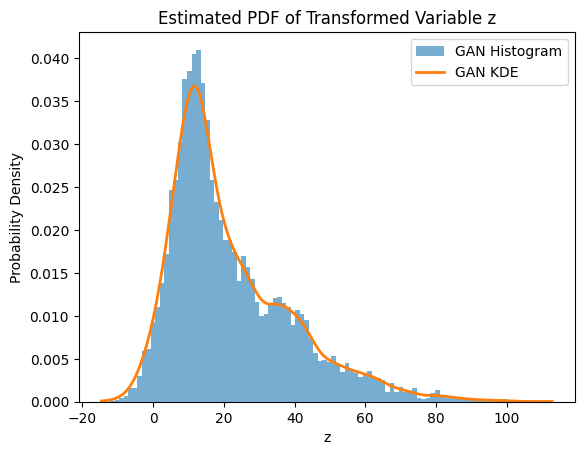

In [ ]:
plt.hist(z_fake, bins=100, density=True, alpha=0.6, label="GAN Histogram")

kde = gaussian_kde(z_fake)
z_range = np.linspace(min(z_fake), max(z_fake), 1000)

plt.plot(z_range, kde(z_range), label="GAN KDE", linewidth=2)

plt.xlabel("z")
plt.ylabel("Probability Density")
plt.title("Estimated PDF of Transformed Variable z")
plt.legend()
plt.show()
